In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd ..

/Users/shhong/Documents/Josefine/pycabnn


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import pycabnn as cbn

/Users/shhong/Documents/Josefine/pycabnn/pycabnn/connector.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [6]:
from pycabnn.util import HocParameterParser

h = HocParameterParser()
config_hoc = str("./test_data/params/Parameters.hoc")
h.load_file(config_hoc)


In [7]:
mli = cbn.create_population("MLI", h)

In [8]:
mli.load_somata("../big_test_data/MLIcoordinates.dat")

Successfully read ../big_test_data/MLIcoordinates.dat.


In [9]:
mli.load_data("../big_test_data/MLI_dend_data_20210823.npz")

In [10]:
mli.dends.idx

array([    0,     0,     0, ..., 19723, 19723, 19723])

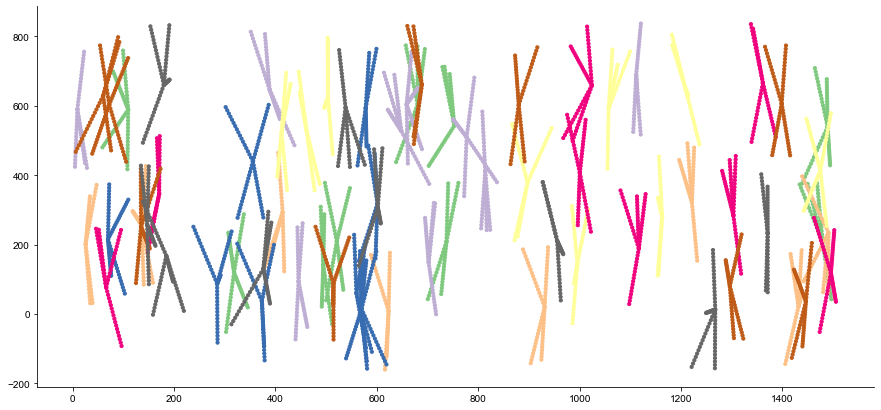

In [11]:
%matplotlib inline
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(mli.dends.coo[:nidx:5,0],mli.dends.coo[:nidx:5,1], 10, mli.dends.idx[:nidx:5], cmap='Accent')

In [12]:
from scipy.spatial import cKDTree

In [13]:
tree = cKDTree(mli.dends.coo)

In [14]:
tree

In [15]:
d = tree.query_pairs(1)
pps = [pp for pp in d if mli.dends.idx[pp[0]]!=mli.dends.idx[pp[1]]]

In [166]:
len(pps)

460980

In [68]:
c1, c2

(13, 1521)

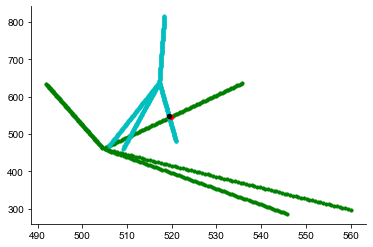

In [153]:
i = 50
c1 = pps[i][0]//360
c2 = pps[i][1]//360

x = 0
y = 1

plt.scatter(mli.dends.coo[(c1*360):((c1+1)*360),x],
            mli.dends.coo[(c1*360):((c1+1)*360),y], 10, 'g')
plt.scatter(mli.dends.coo[(c2*360):((c2+1)*360),x],
            mli.dends.coo[(c2*360):((c2+1)*360),y], 10,'c')
plt.scatter(mli.dends.coo[pps[i][0],x],
            mli.dends.coo[pps[i][0],y], 20, 'r')
plt.scatter(mli.dends.coo[pps[i][1],x],
            mli.dends.coo[pps[i][1],y], 20, 'k')

In [69]:
1//360

0

In [5]:
from sklearn.neighbors import KDTree

sktree = KDTree(mli.dends.coo)
dsk = sktree.query_radius(mli.dends.coo, 2)

NameError: name 'mli' is not defined

In [17]:
from scipy.spatial.distance import pdist

In [18]:
cell_pair = np.array([(mli.dends.idx[pp[0]], mli.dends.idx[pp[1]]) for pp in pps])
cell_pair

array([[ 8734,  9450],
       [ 1925, 12322],
       [ 9972, 19516],
       ...,
       [ 6836,  8730],
       [ 2858,  9264],
       [ 5270,  7041]])

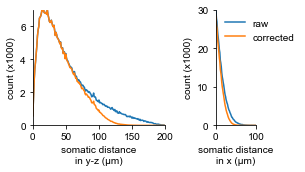

In [70]:
z1 = mli.som[cell_pair[:,0],:]
z2 = mli.som[cell_pair[:,1],:]
z1[:,1] = 0
z2[:,1] = 0

# z3 = mli.som*1.0
# z3[:,1] = 0

dist = np.linalg.norm(z1 - z2, axis=1)
# dist0 = pdist(z3)

n, x = np.histogram(dist,np.arange(201))
n = n/1e3
# n0, x0 = np.histogram(dist0, np.arange(201))

fig = plt.figure(figsize=(4,2.5))
gs = fig.add_gridspec(1, 3)
ax = fig.add_subplot(gs[0, 0:2])

ax.plot(x[:-1], n, label='raw')
ax.plot(x[:-1], n*1/(1+np.exp((x[:-1]-105)/12)), label='corrected')
# ax.plot(x0[:-1], n0)
ax.set(
    xlim=[0, 200], ylim=[0, 7],
    xlabel='somatic distance\nin y-z (μm)',
    ylabel='count (x1000)'
)
# ax.legend()

z1 = mli.som[cell_pair[:,0],:]
z2 = mli.som[cell_pair[:,1],:]
z1[:,1] = 0
z2[:,1] = 0
z1[:,2] = 0
z2[:,2] = 0

dist = np.linalg.norm(z1 - z2, axis=1)

n, x = np.histogram(dist,100)
n = n/1e3
ax = fig.add_subplot(gs[0, 2])
ax.plot(x[:-1], n, label='raw')
ax.plot(x[:-1], n*1/(1+np.exp((x[:-1]-30)/10)), label='corrected')
ax.set(
    xlim=[0, 100],
    ylim=[0, 30],
    xlabel='somatic distance\nin x (μm)',
    ylabel='count (x1000)'
)
ax.legend()

plt.tight_layout()
plt.savefig('ngap_vs_dist.png', dpi=600)

In [69]:
!open .

In [224]:
z1 = mli.som[cell_pair[:,0],:]
z2 = mli.som[cell_pair[:,1],:]
z1[:,1] = 0
z2[:,1] = 0
z1[:,2] = 0
z2[:,2] = 0

dist = np.linalg.norm(z1 - z2, axis=1)

[(0.0, 100.0), (0.0, 30000.0)]

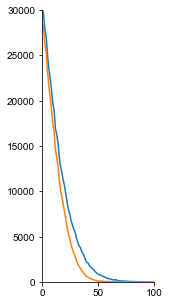

In [233]:
n, x = np.histogram(dist,100)
_, ax = plt.subplots(figsize=(2,5))
ax.plot(x[:-1], n)
ax.plot(x[:-1], n*1/(1+np.exp((x[:-1]-30)/10)))
ax.set(xlim=[0, 100], ylim=[0, 30000])